# Generalized Linear Models

### Environment Setup
**⚠️Note: If running on a new environment, run this cell once and then restart the kernel⚠️**

In [1]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [54]:
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from numpy.linalg import inv
from scipy import interpolate

%matplotlib inline

### Downloading Files

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-717038285/sub-717038285_ses-732592105.nwb"
download_loc = "."
dandi_api_key = None

In [4]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.58.0) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Selecting Neurons

In [5]:
spike_times = nwb.units[0].spike_times.item()

### Making Stim Trace

In [69]:
flashes_table = nwb.intervals["flashes_presentations"]
flashes_table[:10]

,start_time,stop_time,stimulus_name,stimulus_block,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,
0,1282.632614,1282.882832,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3647, 1, timestamps pynwb.base.TimeSeries at..."
1,1284.634334,1284.884540,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3648, 1, timestamps pynwb.base.TimeSeries at..."
2,1286.636014,1286.886217,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3649, 1, timestamps pynwb.base.TimeSeries at..."
3,1288.637634,1288.887855,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3650, 1, timestamps pynwb.base.TimeSeries at..."
4,1290.639354,1290.889562,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3651, 1, timestamps pynwb.base.TimeSeries at..."
5,1292.641034,1292.891240,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3652, 1, timestamps pynwb.base.TimeSeries at..."
6,1294.642714,1294.892917,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3653, 1, timestamps pynwb.base.TimeSeries at..."
7,1296.644364,1296.894572,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3654, 1, timestamps pynwb.base.TimeSeries at..."
8,1298.646074,1298.896272,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3655, 1, timestamps pynwb.base.TimeSeries at..."


In [98]:
bin_res = np.mean(np.diff(flashes_table.start_time)) / 3
interp_hz = 1/bin_res
interp_hz

1.4987460323884054

In [103]:
colors = flashes_table.color
flash_frames = np.zeros(len(colors))
for i, color in enumerate(colors):
    if color == "1.0":
        flash_frames[i] = 1

In [104]:
first_stim_time = flashes_table.start_time[0]
last_stim_time = flashes_table.stop_time[-1]
print(first_stim_time, last_stim_time)

time_axis = np.arange(first_stim_time, last_stim_time, step=(1/interp_hz))
f = interpolate.interp1d(flashes_table.start_time, flash_frames, axis=0, kind="nearest", fill_value="extrapolate")
interp_flashes = f(time_axis)

1282.6326142945445 1581.1321471083802


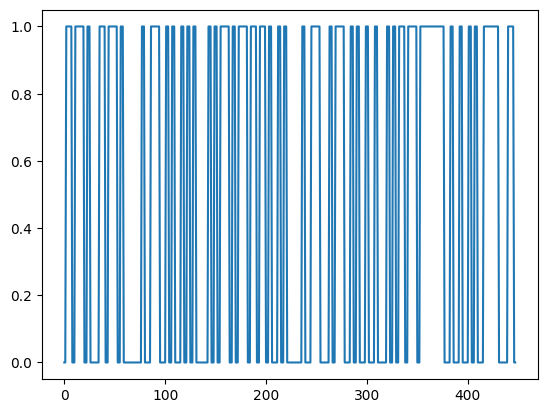

In [105]:
plt.plot(interp_flashes)

### Getting Running Stim

In [106]:
running_data = nwb.processing["running"]["running_speed"].data
running_timestamps = nwb.processing["running"]["running_speed"].timestamps

In [108]:
start_idx, end_idx = np.searchsorted(running_timestamps, [first_stim_time, last_stim_time])
running_data_slice = running_data[start_idx:end_idx]
running_timestamps_slice = running_timestamps[start_idx:end_idx]

In [109]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(running_timestamps_slice[0], running_timestamps_slice[-1], step=(1/interp_hz))
f = interpolate.interp1d(running_timestamps_slice, running_data_slice, axis=0, kind="nearest", fill_value="extrapolate")
interp_running = f(time_axis)

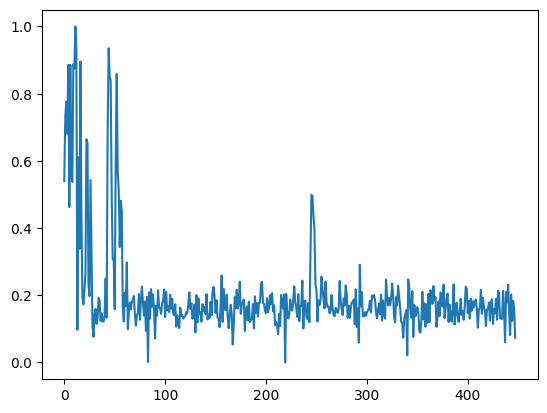

In [118]:
# plt.plot(interp_running)
norm_running = (interp_running-np.min(interp_running)) / (np.max(interp_running)-np.min(interp_running))
plt.plot(norm_running)

In [122]:
print(len(interp_flashes))
print(len(norm_running))

448
448


### Combine Stims

In [128]:
# coefficient to add running to stimulus
mod_coef = 0.5

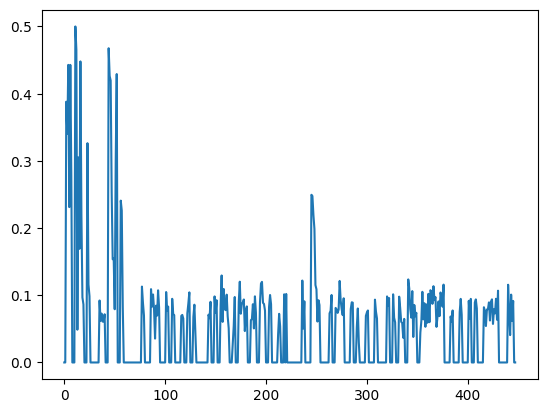

In [131]:
exog = interp_flashes * (norm_running * mod_coef)
plt.plot(exog)

### Building Design Matrix

In [132]:
ntfilt = 50

In [133]:
def get_design_mat(ntfilt, stim, num_time_bins):
    padded_stim = np.hstack((np.zeros((ntfilt-1)), stim)) # pad early bins of stimulus with zero
    design_mat = np.zeros((num_time_bins,ntfilt))
    for j in np.arange(num_time_bins):
        design_mat[j] = padded_stim[j:j+ntfilt] # grab last 'nkt' bins of stmiulus and insert into this row
    return design_mat

In [134]:
num_time_bins = len(exog)
design_mat = get_design_mat(ntfilt, exog, num_time_bins)

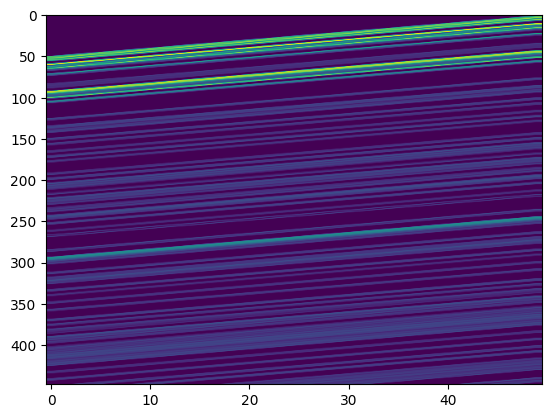

In [135]:
plt.imshow(design_mat, aspect="auto")

### Getting STA

In [136]:
num_spikes = len(spike_times)
spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
spikes_binned,_ = np.histogram(spike_times, spikes_bin_centers)

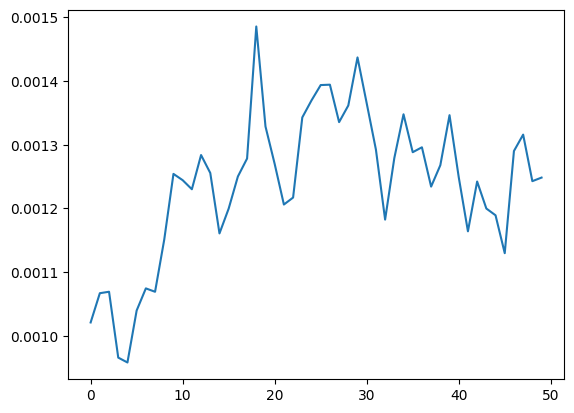

In [137]:
sta = (design_mat.T @ spikes_binned) / num_spikes
plt.plot(sta)

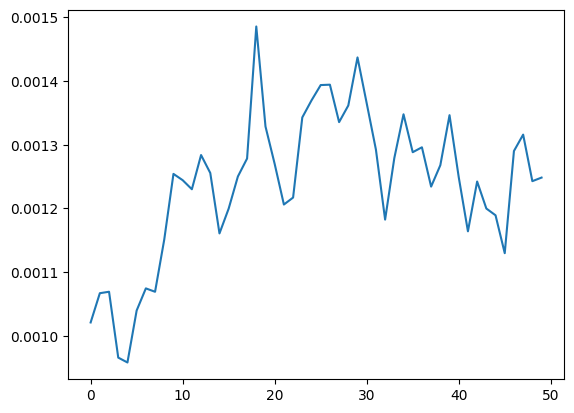

In [138]:
wsta = inv(design_mat.T @ design_mat) @ sta * num_spikes
plt.plot(sta)

### Running MLE

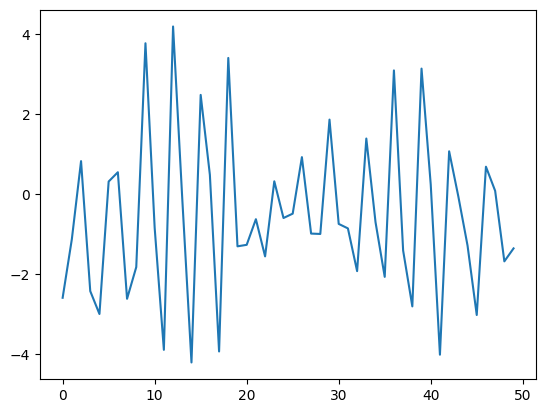

In [139]:
design_mat_offset = np.hstack((np.ones((num_time_bins,1)), design_mat)) # just add a column of ones

glm_poisson_exp = sm.GLM(endog=spikes_binned, exog=design_mat_offset,
                         family=sm.families.Poisson())

pGLM_results = glm_poisson_exp.fit(max_iter=100, tol=1e-6, tol_criterion='params')


# pGLM_const = glm_poisson_exp[-1].fit_['beta0'] # constant ("dc term)")
pGLM_const = pGLM_results.params[0]
pGLM_filt = pGLM_results.params[1:] # stimulus filter

plt.plot(pGLM_filt)

### running on many cells

In [140]:
def get_filter(spike_times):
    spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
    spikes_binned,_ = np.histogram(spike_times, spikes_bin_centers)

    print(len(spike_times))

    glm_poisson_exp = sm.GLM(endog=spikes_binned, exog=design_mat_offset,
                         family=sm.families.Poisson())
    pGLM_results = glm_poisson_exp.fit(max_iter=100, tol=1e-6, tol_criterion='params')
    pGLM_filt = pGLM_results.params[1:] # stimulus filter
    return pGLM_filt

In [141]:
pGLM_results

In [142]:
filters = []
for i in range(100):
    try:
        if nwb.units[i].quality.item() == "good":
            print(i)
            filter = get_filter(nwb.units[i].spike_times.item())
            filters.append(filter)
    except:
        continue

0
19167
1
54029
2
18905
3
44339


4
20540
5
58866
6
158831
7
83
8
19246
9
4679
10
48611
11
152609
12
56734
13
558
14
3466
15
13
16
45937
17
236
18
2940
19
18756
20
17481
21
46140
22
1912


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)


23
2308
24
40692
25
33078
26
10227
27
39899
28
59805
29
137977
30
56470
31
995
32
15223
33
124426
34
134785
35
353
36
6146
37
15482
38
78548
39
97823
40
33855
42
83601
43
17813
44
35219
45
64737
46
38922
47
2230
48
190
49
48800
50
39773
51
368
52
434
53
1078
54
20176
55
13440
56
22006
57
3188
58
33034
59
9015
60
8711
61
9393
62
66418
63
29754
64
31124
65
35718
66
27698
67
210
68
65500
69
33432
70
95365
71
8549
72
5897
73
76099
74
66870
75
14873
76
102323
77
113259
78
31123
79
60666
80
127896
81
15510
82
16362
83
1954
84
6925
85
30378
86
16047
87
3417
88
1905
89
18204
90
12515
91
20467
92
23954
93
62574
94
18903
95
12662
96
58142
97
43127
98
2482
99
19586


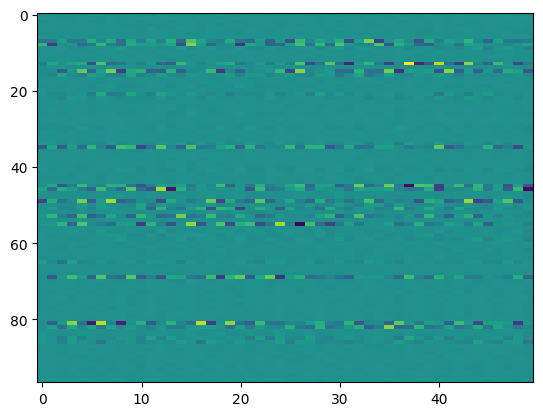

In [143]:
plt.imshow(np.array(filters), aspect="auto")

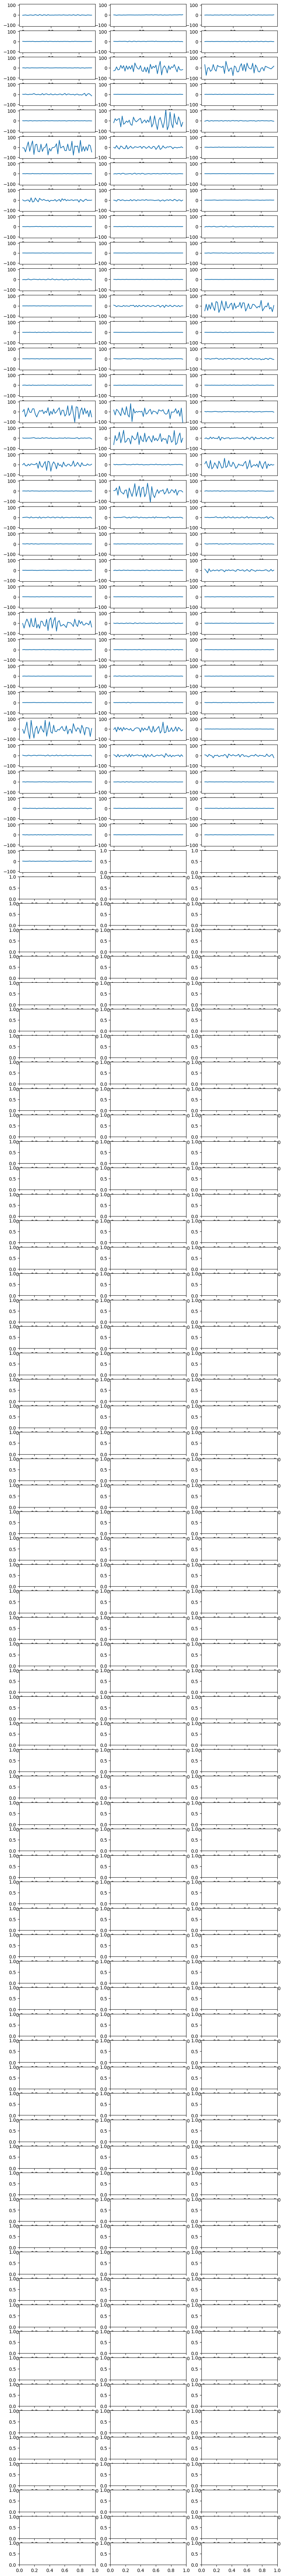

In [145]:
ymax, ymin = 0, 0
for i in range(len(filters)):
    filter = filters[i]
    if max(filter) > ymax:
        ymax = max(filter)
    if min(filter) < ymin:
        ymin = min(filter)

fig, axes = plt.subplots(len(filters), 3, figsize=(10,100))
for i in range(len(axes)):
    filter = filters[i]
    row = i // 3
    col = i % 3
    axes[row][col].plot(filter)
    axes[row][col].set_ylim([ymin, ymax])

### Attempting usage